### 1. Load data

The dataset comes from a [DeepLearning.ai course](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow?specialization=tensorflow-in-practice) on Convolutional Neural Network. It contains graphically generated images of human and horse.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

In [3]:
import zipfile

zip_folder = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(zip_folder, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [4]:
zip_valid_folder = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(zip_valid_folder, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [5]:
import os

horses_dir = os.path.join('/tmp/horse-or-human/horses')
humans_dir = os.path.join('/tmp/horse-or-human/humans')

horse_filenames = os.listdir(horses_dir)
human_filenames = os.listdir(humans_dir)

print('human images: ', len(horse_filenames))
print('horse images: ', len(human_filenames))

human images:  500
horse images:  527


In [6]:
horses_valid_dir = os.path.join('/tmp/validation-horse-or-human/horses')
humans_valid_dir = os.path.join('/tmp/validation-horse-or-human/humans')

horse_valid_filenames = os.listdir(horses_valid_dir)
human_valid_filenames = os.listdir(humans_valid_dir)

print('human images: ', len(horse_valid_filenames))
print('horse images: ', len(human_valid_filenames))

human images:  128
horse images:  128


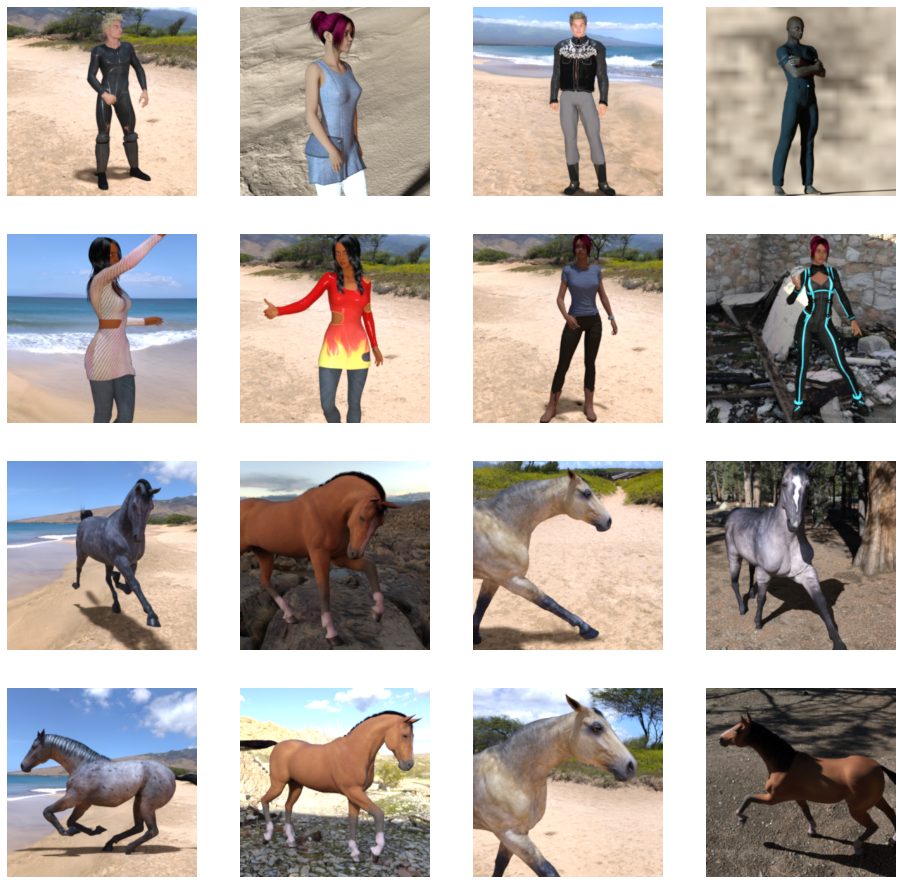

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

nrows = 4
ncols = 4
npictures = 8

fig = plt.gcf()
fig.set_size_inches(nrows * 4, ncols * 4) # 1 inch per image

human_pics_paths = [ os.path.join(humans_dir, pic_path) for pic_path in random.sample(human_filenames, k=npictures) ]
horse_pics_paths = [ os.path.join(horses_dir, pic_path) for pic_path in random.sample(horse_filenames, k=npictures) ]

for i,img_path in enumerate(human_pics_paths + horse_pics_paths):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### 2. Data preparation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img_generator = generator.flow_from_directory(
    '/tmp/horse-or-human',
    target_size=(300,300),
    batch_size=128,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [9]:
valid_generator = ImageDataGenerator(rescale=1/255)
valid_img_generator = valid_generator.flow_from_directory(
    '/tmp/validation-horse-or-human',
    target_size=(300,300),
    batch_size=32,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


### 3. Training and evaluation

Use pre-trained weights on InceptionV3 model for the downstream task (classification of human vs horse image).

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications import InceptionV3

weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    weights = weights_file,
    input_shape = (300, 300, 3),
    include_top = False
)

for layer in pre_trained_model.layers:
    layer.trainable=False

In [12]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
pre_trained_output = pre_trained_model.get_layer('conv2d_93').output
print(pre_trained_output.shape)

(None, 8, 8, 192)


In [14]:
import tensorflow as tf

x = tf.keras.layers.Flatten()(pre_trained_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.models.Model(inputs = pre_trained_model.input, outputs = x)

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=RMSprop(lr=0.001))

In [16]:
history = model.fit_generator(
    img_generator,
    steps_per_epoch=8,
    epochs=10,
    verbose=1,
    validation_data=valid_img_generator,
    validation_steps=8
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
8/8 [==============================] - 63s 3s/step - loss: 0.4690 - acc: 0.7428 - val_loss: 0.0167 - val_acc: 0.9961
Epoch 2/10
8/8 [==============================] - 23s 3s/step - loss: 0.0078 - acc: 0.9957 - val_loss: 0.0085 - val_acc: 0.9961
Epoch 3/10
8/8 [==============================] - 23s 3s/step - loss: 0.0059 - acc: 0.9988 - val_loss: 0.0042 - val_acc: 0.9961
Epoch 4/10
8/8 [==============================] - 23s 3s/step - loss: 0.0058 - acc: 0.9962 - val_loss: 2.2975e-04 - val_acc: 1.0000
Epoch 5/10
8/8 [==============================] - 23s 3s/step - loss: 0.0042 - acc: 0.9981 - val_loss: 5.7049e-04 - val_acc: 1.0000
Epoch 6/10
8/8 [==============================] - 23s 3s/step - loss: 0.0059 - acc: 0.9974 - val_loss: 1.1559e-04 - val_acc: 1.0000
Epoch 7/10
8/8 [==============================] - 23s 3s/step - loss: 0.0318 - acc: 0.9890 - val_loss: 7.6789e-04 - val_acc: 1.0000
Epoch 8/10
8/8 [==============================] - 24s 3s/step - loss: 0.0035 - acc: 0.99

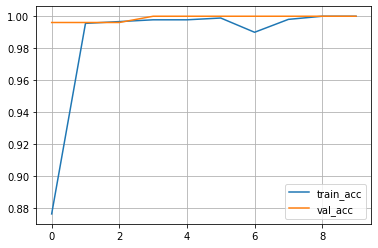

In [17]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

epochs = range(len(history.epoch))

plt.plot(epochs, accuracy, label='train_acc')
plt.plot(epochs, val_accuracy, label='val_acc')
plt.grid(True)
plt.legend()
plt.show()

Another way to train a CNN is to build and train a model from scratch.

In [18]:
''' 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=RMSprop(lr=0.001))
history = model.fit_generator(
    img_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    validation_data=valid_img_generator,
    validation_steps=8
)

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

epochs = range(len(history.epoch))

plt.plot(epochs, accuracy, label='train_acc')
plt.plot(epochs, val_accuracy, label='val_acc')
plt.grid(True)
plt.ylim([0, 1.])
plt.legend()
plt.show()
'''

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 33, 33, 64)        3

### 4. Explore filters

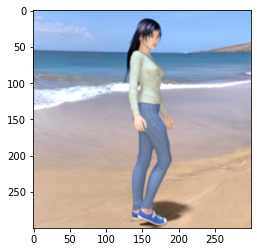

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_sample = humans_dir + '/' + random.choice(human_filenames)
img = image.load_img(img_sample)
plt.imshow(img)

In [20]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img.shape

(1, 300, 300, 3)

In [21]:
label = model.predict(img)[0]
if label == 0:
    print('horse')
else:

    print('human')

human


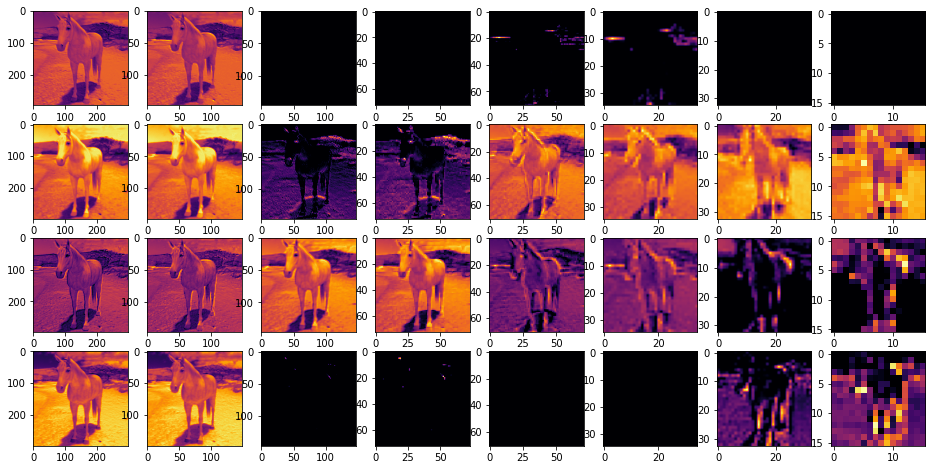

In [22]:
from tensorflow.keras.models import Model

nlayers = 8
nfilters = 4
kernels = [1, 4, 8, 15]
f, sp = plt.subplots(nfilters, nlayers, figsize=(nlayers * 2, nfilters * 2))

output_layers = [ layer.output for layer in model.layers ][: nlayers]
layer_names = [ layer.name for layer in model.layers ][: nlayers]
activation_model = Model(inputs = model.input, outputs = output_layers)

image_path = os.path.join(horses_dir, 'horse01-0.png')
img = image.load_img(image_path, target_size=(300,300))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

feature_maps = activation_model(img)
for i, layer_name in enumerate(layer_names):
    for j in range(nfilters):
        kernel = kernels[j]
        fmap = feature_maps[i][0, :, :, kernel]
        sp[j,i].imshow(fmap, cmap = 'inferno') # (feature maps, layers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


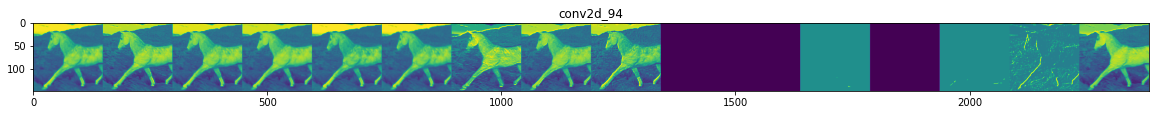

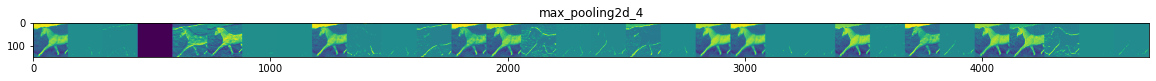

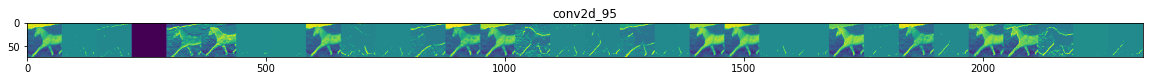

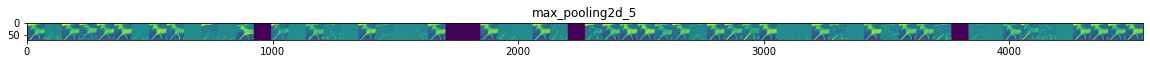

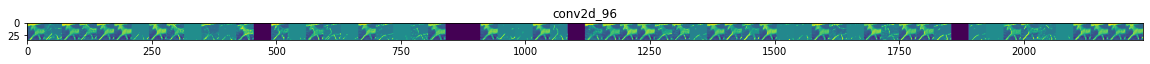

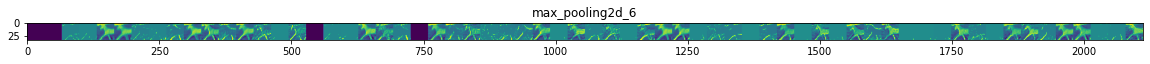

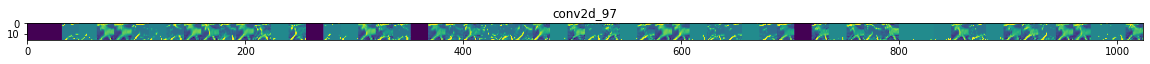

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

import random
import numpy as np

output_layers = [ layer.output for layer in model.layers[1:] ]
layer_names = [ layer.name for layer in model.layers ]
activation_model = Model(inputs = model.input, outputs = output_layers)

fnames = human_filenames + horse_filenames
sample = random.choice(fnames)
if 'human' in sample:
    img_path = os.path.join(humans_dir, sample)
else:
    img_path = os.path.join(horses_dir, sample)

image = load_img(img_path, target_size=(300, 300))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

filters = activation_model.predict(image)

for layer_name, feature_map in zip(layer_names, filters):
    
    if len(feature_map.shape) == 4:

        n_features = feature_map.shape[-1]
        dim = feature_map.shape[1]

        display = np.zeros((dim, dim * n_features))
        for i in range(n_features):
            feature = feature_map[0, :, :, i]
            feature -= feature.mean()
            feature /= feature.std()
            feature *= 64  
            feature += 128 
            feature = np.clip(feature, 0, 255).astype('uint8')

            display[:, i * dim : (i + 1) * dim] = feature
        
        scale = 20.0 / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.grid(False)
        plt.title(layer_name)
        plt.imshow(display, cmap='viridis', aspect='auto')